<a href="https://colab.research.google.com/github/HammadB/ProceduralLayout/blob/master/Layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pyaml
!pip install Shapely

    100% |████████████████████████████████| 1.5MB 9.2MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import copy
import json as json
import yaml
from shapely.affinity import rotate, translate
from shapely.geometry import box

In [0]:
class Constraint(object):
  
  def __init__(self, layout):
    self.layout = layout
  
  def evaluate_cost(self):
    return 0
  
  def set_layout(self, layout):
    self.layout = layout
  
  def get_layout(self):
    return self.layout
  
  def get_layoutObject(self, index):
    return self.layout.getLayoutObjects()[index]
  
  def get_all_layoutObjects_by_indices(self, indicies):
    return [self.get_layoutObject(i) for i in indicies]
    
class AreaConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    super().__init__(layout)
    
   #TODO: change to cascaded union
  def evaluate_cost(self):
    sumOfAreas = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for i in range(len(layoutObjects)):
      for j in range(i + 1, len(layoutObjects)):
        sumOfAreas += layoutObjects[i].get_intersection(layoutObjects[j])
    return sumOfAreas

#Special constraint for plane checking
class BoundaryConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    super().__init__(layout)
    
  def evaluate_cost(self):
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for layoutObject in layoutObjects:
      bbox = layoutObject.getPlane()
      if not(bbox.box.contains(layoutObject.box)):
        return float("inf")
    return 0

class FacingConstraint(Constraint):
  
  def __init__(self, layoutObjectIndicies, toFaceIndicies, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    self.toFaceIndicies = toFaceIndicies
    super().__init__(layout)
    
  def evaluate_cost(self):
    cost = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    facingObjects = self.get_all_layoutObjects_by_indices(self.toFaceIndicies)
    for layoutObj in layoutObjects:
      min_angle = float('inf')
      for candidate in facingObjects:
        min_angle = min(min_angle, layoutObj.get_angle_to_other_object(candidate))
      cost += min_angle
    return 1/(len(layoutObjects)) * cost # average angle cost

  
class DirectionConstraint(Constraint):
  #direciton is a tuple
  def __init__(self, layoutObjectIndicies, direction, layout):
    self.layoutObjectIndicies = layoutObjectIndicies
    self._direction = direction
    super().__init__(layout)

  def evaluate_cost(self):
    cost = 0
    layoutObjects = self.get_all_layoutObjects_by_indices(self.layoutObjectIndicies)
    for layoutObject in layoutObjects:
      cost += layoutObject.get_angle_to_direction(self._direction)
    return cost / len(layoutObjects)

[-0.1 -0.1  0.1  0.1]
[-0.25 -0.25  0.25  0.25]
[-0.25 -0.25  0.25  0.25]
[ 9.625  1.75  10.375  2.25 ]
[ 9.75  1.75 10.25  2.25]
[-0.25 -0.25  0.25  0.25]
[ 9.575  1.75  10.425  2.25 ]


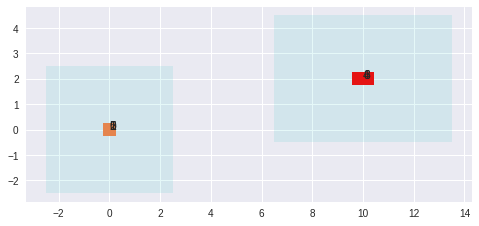

In [9]:
class Rectangle(object):
  
  def __init__(self, center=None, dim1=None, dim2=None, _targetBox=None, _targetPaddedBox=None, className=None):
    """
    center: (x, y)
    dim1 = x dimension
    dim2 = y dimension 
    """
    padding = self.get_padding()
    
    if(_targetBox != None):
      self.box = _targetBox
      assert _targetPaddedBox != None
      self.padded_box = _targetPaddedBox
    else:
      center_x = center[0]
      center_y = center[1]
      self.box = box(center_x - dim1/2., center_y - dim2/2., center_x + dim1/2., center_y + dim2/2.)
      self.padded_box = box(center_x - dim1/2., center_y - dim2/2., center_x + dim1/2., center_y + dim2/2.)
#       if rot != 0:
#         self.box = rotate(self.box, rot, origin='center', use_radians=False)
#         self.padded_box = rotate(self.padded_box, rot, origin='center', use_radians=False)
    self._myPlane = None
    if className == None:
      self.className = "default"
    else:
      self.className = className
  
  def get_padding(self):
    return (0, 0, 0, 0) #left, right, top, bottom
  
  def set_padding(self, padding):
    center_x, center_y = self.center
    bounds = self.box.bounds # minx, miny, maxx, maxy
    self.padded_box = box(bounds[0] - padding[0], bounds[1] - padding[3], bounds[2] + padding[1], bounds[3] + padding[2])
  
  def get_class(self):
    return self.className
  
  def update_center(self, center):
    """
    Moves the rectangle to a new center (tuple/array) while maintaining current rotation. 
    """
    bounds = self.box.bounds
    center_x = (bounds[0] + bounds[2]) / 2. 
    center_y = (bounds[1] + bounds[3]) / 2. 
    displace_x = center[0] - center_x
    displace_y = center[1] - center_y 
    self.box = translate(self.box, displace_x, displace_y)
    self.padded_box = translate(self.padded_box, displace_x, displace_y)
    
  def get_translated(self, xoff=0.0, yoff=0.0, zoff=0.0):
    new_box = translate(self.box, xoff, yoff, zoff)
    new_padded = translate(self.padded_box, xoff, yoff, zoff)
    return Rectangle(_targetBox=new_box, _targetPaddedBox=new_padded)
 
  def get_rotated(self, angle):
    new_box = rotate(self.box, angle, origin='center', use_radians=False)
    new_padded = rotate(self.padded_box, angle, origin='center', use_radians=False)
    return Rectangle(_targetBox=new_box, _targetPaddedBox=new_padded)
  
  def get_intersection(self, rect2):
    intersection = self.padded_box.intersection(rect2.padded_box)
    return intersection.area
  
  def get_area(self):
    return self.box.area
    
  @property
  def center(self):
    bounds = self.box.bounds
    center_x = (bounds[0] + bounds[2]) / 2. 
    center_y = (bounds[1] + bounds[3]) / 2. 
    return (center_x, center_y)    
  
  def get_angle_to_other_object(self, rect2):
    """
    Returns angle (0 to 180) between left side of current object and
    center of rect2
    """
    top_left = np.array(self.box.exterior.coords[2])
    bottom_left = np.array(self.box.exterior.coords[3])
        
    vector1 = top_left - bottom_left
    vector2 = np.array(rect2.center) - np.array(self.center)
    
    return Rectangle.get_angle(vector1, vector2)
  
  def get_angle_to_direction(self, direction):
    top_left = np.array(self.box.exterior.coords[2])
    bottom_left = np.array(self.box.exterior.coords[3])
    vector1 = top_left - bottom_left

    return Rectangle.get_angle(vector1, np.array(direction))
  
  
  @staticmethod
  def get_angle(vector1, vector2): 
    # vector1, vector2 are np arrays, returns in degrees
    dot_product = np.dot(vector1, vector2)
    norma = np.dot(vector1, vector1)
    normb = np.dot(vector2, vector2)
    return np.arccos(dot_product / (norma * normb)**(1./2)) * (180/np.pi)    
  
  def setPlane(self, plane):
    self._myPlane = plane

  def getPlane(self):
    return self._myPlane
  
  
class Layout(object):
  
  def __init__(self, layoutObjects, planeBoxes, doAssignment=False, environmentBoxes=[]):
    self._myLayoutObjects = layoutObjects
    self.planeBoxes = planeBoxes
    self.environmentBoxes = environmentBoxes
    self._myConstraints = []
    if doAssignment:
      self._assignBoxes()
    
  def _assignBoxes(self):
    for layoutObj in self._myLayoutObjects:
      objArea = layoutObj.get_area()
      allPlaneBoxes = self.getAllPlaneBoxes()
      indexes = np.arange(len(allPlaneBoxes))
      np.random.shuffle(indexes)
      for j in indexes:
        candidatePlane = allPlaneBoxes[j]
        if objArea < candidatePlane.get_area():
          layoutObj.setPlane(candidatePlane)
          layoutObj.update_center(candidatePlane.center)
          break
      
  def getLayoutObjects(self):
    return self._myLayoutObjects
  
  #Returns only non-enviornment planes
  def getPlaneBoxes(self):
    return self.planeBoxes
  
  #Returns all planes, environment included
  def getAllPlaneBoxes(self):
    return self.planeBoxes + self.environmentBoxes
  
  def getClassToObjects(self):
    classToObj = {}
    for layoutObject in self._myLayoutObjects:
      className = layoutObject.get_class()
      if className not in classToObj:
        classToObj[className] = []
      classToObj[className].append(layoutObject)
    return classToObj
  
  def addConstraint(self, constraint):
    self._myConstraints.append(constraint)
  
  def getConstraints(self):
    return self._myConstraints
  
  def drawLayout(self):
    plt.axes()
    x = np.arange(len(self._myLayoutObjects))
    ys = [i+x+(i*x)**2 for i in range(len(self._myLayoutObjects))]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    #For now all layout objects are Boxes
    i = 0
    for box in self._myLayoutObjects:
      print(np.array(box.box.bounds))
      shape = plt.Polygon(np.array(box.box.exterior.coords), fc=colors[i])
      plt.gca().add_patch(shape)
      #label the box
      plt.text(box.center[0], box.center[1], str(i))
      i += 1
    #bounding box
    for planeBox in self.getAllPlaneBoxes():
      color = "c"
      if planeBox in self.environmentBoxes:
        color="d"
      shape = plt.Polygon(np.array(planeBox.box.exterior.coords), fc=color, alpha=0.1)
      plt.gca().add_patch(shape)
    plt.axis('scaled')
    plt.show()
   
  def __copy__(self):
    newLayoutObjects = []
    for layoutObject in self.getLayoutObjects():
      newLayoutObject = copy(layoutObject)
      newLayoutObjects.append(newLayoutObject)
    return Layout(*newLayoutObjects) 
  
  
b = Rectangle((0, 0), 0.2, 0.2)
b2 = Rectangle((0, 0),  0.5, 0.5)
b3 = Rectangle((0, 0),  0.5, 0.5)
b4 = Rectangle((0, 0),  0.75, 0.5)
b5 = Rectangle((0, 0),  0.5, 0.5)
b6 = Rectangle((0, 0),  0.5, 0.5)
b7 = Rectangle((0, 0),  0.5, 0.5)
b7 = Rectangle((0, 0),  0.85, 0.5)
boxes = [b, b2, b3 ,b4, b5, b6, b7]

bounds = Rectangle((0, 0),  5, 5)
bounds2 = Rectangle((10, 2), 7, 5)
layout = Layout([b, b2, b3 ,b4, b5, b6, b7], [bounds, bounds2], doAssignment=True)
layout.drawLayout()
    


In [0]:
def parse_constraint_yaml(file_name):
  with open(file_name, 'r') as layoutdef:
    data = layoutdef.read()
    parsed = yaml.load(data)
    return parsed['classes']
  
def get_attributes_for_class(class_name, constraint_def):
  for class_def in constraint_def:
    dotted_name = '.' + class_name 
    if dotted_name in class_def:
      return class_def[dotted_name]
    
def create_constraints_from_yaml(file_name, layout):
  constraint_def = parse_constraint_yaml(file_name)
  classNameToLayoutObjects = layout.getClassToObjects()
  for className in classNameToLayoutObjects:
    attrs = get_attributes_for_class(className, constraint_def)
    if attrs == None:
      return
    layoutObjects = classNameToLayoutObjects[className]
    for attr in attrs:
      dispatch_attribute(attr, layoutObjects, layout)
      
  #add the two default constraints
  allObjectIndicies = list(range(len(layout.getLayoutObjects())))
  layout.addConstraint(BoundaryConstraint(allObjectIndicies, layout))
  layout.addConstraint(AreaConstraint(allObjectIndicies, layout))
     
def get_inidices_list_for_layoutObjects(subset_layoutObject, layout):
  all_layoutObjects = layout.getLayoutObjects()
  ans = [all_layoutObjects.index(obj) for obj in subset_layoutObject]
  return ans
    
def dispatch_attribute(attr, layoutObjects, layout):
  attrName = list(attr.keys())[0]
  if attrName == 'padding':
    handle_padding(layoutObjects, attr['padding'])
  if attrName == 'facing':
    handle_facing(layoutObjects, attr['facing'][1:], layout)
  if attrName == 'direction':
    handle_direction(layoutObjects, attr['direction'])

def handle_padding(layoutObjects, paddingString):
  padding = [float(x) for x in paddingString.split(',')] #LRTB
  for layoutObject in layoutObjects:
    layoutObject.set_padding(padding)
  
def handle_facing(layoutObjects, facingClass, layout):
    classNameToLayoutObjects = layout.getClassToObjects()
    if facingClass not in classNameToLayoutObjects:
      return
    facingObjects = classNameToLayoutObjects[facingClass]
    constraint = FacingConstraint(get_inidices_list_for_layoutObjects(layoutObjects, layout), 
                                  get_inidices_list_for_layoutObjects(facingObjects, layout),
                                  layout)
    layout.addConstraint(constraint)
    
def handle_direction(layoutObjects, directionString):
  directionTuple = tuple([float(x) for x in directionString[1:-1].split(',')]) #<X, Y>
  constraint = DirectionConstraint(get_inidices_list_for_layoutObjects(layoutObjects, layout), 
                                   directionTuple,
                                   layout)
  layout.addConstraint(constraint)

b  =  Rectangle((0, 0), 0.7, 0.04, className="test1")
b2 = Rectangle((0, 0),  4, 3.1, className="test1")
b3 = Rectangle((0, 0),  0.5, 0.5, className="test2")
# b4 = Rectangle((0, 0),  0.75, 0.5, className="test1")
# b5 = Rectangle((0, 0),  1.2, 1.5, className="test1")
# b6 = Rectangle((0, 0),  0.5, 0.5, className="test2")
# b7 = Rectangle((0, 0),  0.5, 0.5, className="test1")
# b7 = Rectangle((0, 0),  0.85, 2, className="test1")

bounds = Rectangle((0, 0),  5, 5)
bounds2 = Rectangle((10, 2), 7, 5)
layout = Layout([b, b2, b3], [bounds], doAssignment=True)

create_constraints_from_yaml('test.yaml', layout)
  

[-0.35 -0.25  0.35  0.25]
[-1. -1.  1.  1.]
[-0.35 -0.25  0.35  0.25]
[-0.35 -0.25  0.35  0.25]
[-0.35 -0.25  0.35  0.25]


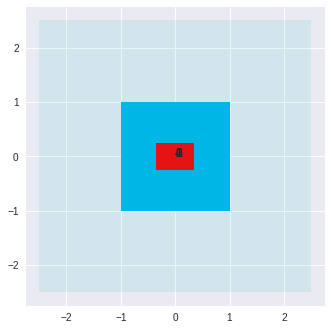

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


[ 1.2390865  -1.99392983  2.07969793 -1.1395089 ]
[-2.24606981 -0.11127247 -0.24553622  1.88926112]
[ 0.63218469 -1.13535776  1.44464211 -0.27513412]
[ 0.17509409 -0.53159396  0.95094363  0.32282401]
[-1.66945992 -2.15763039 -0.96645865 -1.65341989]


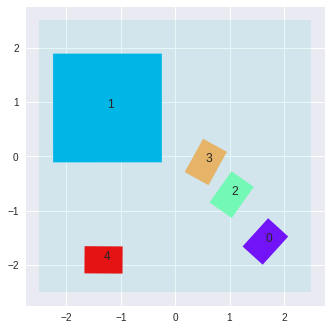

In [11]:
def boltzmann(cost, beta=1.0):
  return np.exp(-beta*cost)

def acceptanceProbability(current_cost, proposed_cost):
  return min(1, boltzmann(proposed_cost)/boltzmann(current_cost))


def get_cost(layout, constraints):
  layoutObjects = layout.getLayoutObjects()
  cost = 0

  for constraint in constraints:
    constraint.set_layout(layout)
    cost += constraint.evaluate_cost()

  return cost


def propose_new_layout(current_layout, prob_swap_plane, perturb, rotate_perturb):
  new_layout_objects = []
  planeBoxes = current_layout.getAllPlaneBoxes()
  layout_objects = current_layout.getLayoutObjects() 
  rotate_index = np.random.randint(len(layout_objects))
  to_rotate = layout_objects[rotate_index]
  
  for i in range(len(layout_objects)):
    rect = layout_objects[i]
    rect_center = rect.center 
    new_rect = rect.get_translated(np.random.normal(scale=perturb), np.random.normal(scale=perturb))
    if i == rotate_index:
        new_rect = new_rect.get_rotated(np.random.normal(scale=rotate_perturb))
     
    new_rect.setPlane(rect.getPlane())
    new_layout_objects.append(new_rect)
  
  if np.random.random() < prob_swap_plane: 
    randomObject = new_layout_objects[np.random.randint(len(new_layout_objects))]
    randomPlane = planeBoxes[np.random.randint(len(planeBoxes))]
    randomObject.setPlane(randomPlane)
    randomObject.update_center(randomPlane.center)
    
  new_layout = Layout(new_layout_objects, planeBoxes)
  return new_layout

def metropolis_hastings(initial_layout, num_iters=10000, prob_swap_plane=0.05, perturb=0.1, rotate_perturb=10):
  cur_cost = get_cost(initial_layout, initial_layout.getConstraints())
  cur_layout = initial_layout
  best_layout = cur_layout
  best_cost = float("inf")
  
  for i in range(num_iters):
    new_layout = propose_new_layout(cur_layout, prob_swap_plane, perturb, rotate_perturb)
    new_cost = get_cost(new_layout, initial_layout.getConstraints())
    if np.random.random() < acceptanceProbability(cur_cost, new_cost):
      cur_layout = new_layout
      cur_cost = new_cost
      if cur_cost < best_cost:
        best_layout = cur_layout
        best_cost = cur_cost
      
  return best_layout

b  =  Rectangle((0, 0), 0.7, 0.5, className="test1")
b3  =  Rectangle((0, 0), 0.7, 0.5, className="test1")
b4  =  Rectangle((0, 0), 0.7, 0.5, className="test1")
b5  =  Rectangle((0, 0), 0.7, 0.5, className="test1")
b2  =  Rectangle((0, 0), 2, 2, className="test2")
bounds = Rectangle((0, 0),  5, 5)
layout = Layout([b, b2, b3, b4, b5], [bounds], doAssignment=True)
layout.drawLayout()

create_constraints_from_yaml('test.yaml', layout)
  
final_layout = metropolis_hastings(layout, num_iters=10000)
final_layout.drawLayout()

# create_constraints_from_yaml('test.yaml', layout)
    
# final_layout = metropolis_hastings(layout, num_iters=1000)
# final_layout.drawLayout()

# b  =  Rectangle((0, 0), 0.7, 0.04, className="test1")
# b2 = Rectangle((0, 0),  4, 3.1, className="test1")
# b3 = Rectangle((0, 0),  0.5, 0.5, className="test1")
# b4 = Rectangle((0, 0),  0.75, 0.5, className="test1")
# b5 = Rectangle((0, 0),  1.2, 1.5, className="test1")
# b6 = Rectangle((0, 0),  0.5, 0.5, className="test2")
# b7 = Rectangle((0, 0),  0.5, 0.5, className="test1")
# b7 = Rectangle((0, 0),  0.85, 2, className="test1")
# boxes = [b, b2, b3 ,b4, b5, b6, b7]

# bounds = Rectangle((0, 0),  5, 5)
# bounds2 = Rectangle((10, 2), 7, 5)
# layout = Layout([b, b2, b3 ,b4, b5, b6, b7], [bounds, bounds2], doAssignment=True)
# layout.drawLayout()

# create_constraints_from_yaml('test.yaml', layout)
    
# final_layout = metropolis_hastings(layout, num_iters=1000)
# final_layout.drawLayout()